In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel,sigmoid_kernel,polynomial_kernel
from cvxpy.atoms.affine.wraps import psd_wrap
import scipy.linalg as LA
from scipy.linalg import block_diag

In [2]:
mu,lam_x2=-5*(np.random.rand(2)).round(2)
print('mu:  ',mu) 
print('lam: ',lam_x2)

mu:   -2.15
lam:  -2.1


In [3]:
# mu=-2
# lam_x2=-0.5
lam_x1=-lam_x2
f_of_x = lambda x:np.array([mu*x[:,0], lam_x2*x[:,1]+lam_x1*x[:,0]**2]).T

A = np.diag((mu, lam_x2))
K = np.array([[mu, 0, 0],[0, lam_x2, lam_x1],[0, 0, mu**2]])
print(A)
print(K)

[[-2.15  0.  ]
 [ 0.   -2.1 ]]
[[-2.15    0.      0.    ]
 [ 0.     -2.1     2.1   ]
 [ 0.      0.      4.6225]]


In [4]:
nc_x1 = 2
nc_x2 = 4
dom = [-1, 1]

x1_ins = np.linspace(dom[0],dom[1],nc_x1)
x2_ins = np.linspace(dom[0],dom[1],nc_x2)
x1im,x2im = np.meshgrid(x1_ins,x2_ins)
x1_ins_m = np.reshape(x1im,(nc_x1*nc_x2,1))
x2_ins_m = np.reshape(x2im,(nc_x1*nc_x2,1))
x_ins_comb = np.append(x1_ins_m,x2_ins_m,1)

X_fx = np.zeros([2,1])
Y_fx = np.zeros([2,1])

X_gx = np.zeros([2,1])
Y_gx = np.zeros([2,1])
idx = 0
eqi_idx = []

for x1,x2 in x_ins_comb:
    if x1==0 and x2==0:
        print('origin')
        eqi_idx.append(idx)
    idx = idx + 1
    
print(eqi_idx)
rmv_idx = eqi_idx

[]


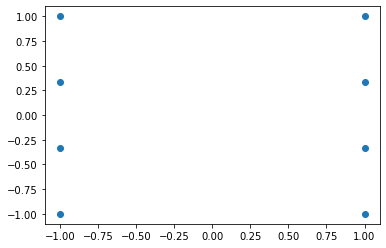

In [5]:
# print(x_ins_comb.shape)
# print(x_ins_comb[:,0].shape)

plt.scatter(x_ins_comb[:,0],x_ins_comb[:,1])
plt.show()
val,zero_idx=np.where([x_ins_comb[:,1]==0])

In [6]:
x_ins_comb.shape

(8, 2)

In [7]:
x_ins_comb[zero_idx].shape

(0, 2)

In [8]:
X_fx = 1*x_ins_comb
Y_fx = f_of_x(X_fx)
print(X_fx.shape)
print(Y_fx.shape)

(8, 2)
(8, 2)


In [9]:
def polyTensor(X, Y, degreelist=[3], coef0=0):
    nx = len(X[:,0])
    N_kernel=len(degreelist)
    KXX_tensor=np.zeros((N_kernel,nx,nx))
    KXY_tensor=np.zeros((N_kernel,nx,nx))
    KYY_tensor=np.zeros((N_kernel,nx,nx))
    for k in range(N_kernel):
        degree = degreelist[k]
             
        KXX_tensor[k,:,:] = polynomial_kernel(X,degree=degree,gamma=1,coef0=coef0)
        KXY_tensor[k,:,:] = polynomial_kernel(X,Y,degree=degree,gamma=1,coef0=coef0)
        KYY_tensor[k,:,:] = polynomial_kernel(Y,degree=degree,gamma=1,coef0=coef0)
        
    print('*** Finished Construcing Polynomial Kernels ***')
    return KXX_tensor, KXY_tensor, KYY_tensor

In [10]:
# if we want to combine more than one rbf kernel
# degrees of kernels
degreelist = [2]
print("List of degrees: ",degreelist)

coef0=0
print("Constant of kernel: ",coef0)

KXX_fx,KXY_fx,KYY_fx = polyTensor(X_fx, Y_fx, degreelist, coef0=coef0)
    
print(KXX_fx.shape)
print(KXY_fx.shape)

List of degrees:  [2]
Constant of kernel:  0
*** Finished Construcing Polynomial Kernels ***
(1, 8, 8)
(1, 8, 8)


In [11]:
# KXX_fx,KXY_fx,KYY_fx = polyTensor(X_fx, Y_fx, N_kernel, degreelist)
# KXX_fx = KXX_fx[:,:,0]
# KXY_fx = KXY_fx[:,:,0]
# KYY_fx = KYY_fx[:,:,0]

# # Symmetry check on KXX: 
# if(np.allclose(KXX_fx, KXX_fx.T)):
#     print('KXX_fx is symmetric! ')
# KYX_fx = KXY_fx.T
    
# print(KXX_fx.shape)
# print(KXY_fx.shape)

In [12]:
KXX_fx_nx = (KXX_fx).reshape((-1,KXX_fx.shape[1]),order='C')
print(KXX_fx_nx.shape)

KXX_fx_d = KXX_fx[0]
for i in range(KXX_fx.shape[0]-1): 
    KXX_fx_d = block_diag(KXX_fx_d, KXX_fx[i+1])
print(KXX_fx_d.shape)

KXY_fx_nx = (KXY_fx).reshape((-1,KXY_fx.shape[1]),order='C')
print(KXY_fx_nx.shape)

KXY_fx_d = KXY_fx[0]
for i in range(KXY_fx.shape[0]-1): 
    KXY_fx_d = block_diag(KXY_fx_d, KXY_fx[i+1])
print(KXY_fx_d.shape)

(8, 8)
(8, 8)
(8, 8)
(8, 8)


In [13]:
# comparison = KXX_fx_nx == KXX_fx_d
# equal_arrays = comparison.all()

# print(equal_arrays)

In [14]:
# cdim_1 = X_fx.shape[1]
# cdim_2 = X_fx.shape[0]
# C = cp.Variable((cdim_1,cdim_2))

# term_1 = cp.sum_squares(C@KXY_fx - A@C@KXX_fx + Y_fx.T - A@X_fx.T)
# term_1 = cp.square(cp.norm(C@KXY_fx - A@C@KXX_fx + Y_fx.T - A@X_fx.T,"fro"))
# term_3 = cp.sum_squares(cp.quad_form(C[0,:],KXX_fx))+cp.sum_squares(cp.quad_form(C[1,:],KXX_fx))

In [15]:
cdim_1 = X_fx.shape[1]
cdim_2 = KXX_fx_nx.shape[0]
C = cp.Variable((cdim_1,cdim_2))

In [16]:
# term_1 = cp.sum_squares(C@KXY_fx - A@C@KXX_fx + Y_fx.T - A@X_fx.T)
term_1 = cp.square(cp.norm(C@KXY_fx_nx - A@C@KXX_fx_nx + Y_fx.T - A@X_fx.T,"fro"))
term_3 = cp.sum_squares(cp.quad_form(C[0,:],psd_wrap(KXX_fx_d)))\
        +cp.sum_squares(cp.quad_form(C[1,:],psd_wrap(KXX_fx_d)))

In [18]:

gamma=1e-8 #0.00002

objective = cp.Minimize(term_1 + gamma*term_3)
prob = cp.Problem(objective)

In [19]:
result = prob.solve(solver='SCS',verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 18 01:34:03 PM: Your problem has 16 variables, 0 constraints, and 0 parameters.
(CVXPY) May 18 01:34:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 18 01:34:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 18 01:34:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 18 01:34:03 PM: Compiling problem (target solver=SCS).
(CVXPY) May 18 01:34:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> 

In [20]:
C_opt = C.value


In [21]:
# import numpy as np
# import scipy.linalg as LA
# mu=-0.2
# lam=-0.5
# A = np.diag((mu,lam))
# deltaT = 0.01
# A = (deltaT*np.diag((mu, lam)))+np.eye(2)

ee,vl,vr=LA.eig(A, left=True, right=True)
w=vl/np.diag(vr@vl.T)
print(w)

[[1. 0.]
 [0. 1.]]


In [22]:
ee_K,vl_K,vr_K=LA.eig(K, left=True, right=True)
w_K=vl_K/np.diag(vr_K@vl_K.T)
print(w_K)

[[ 1.          0.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.         -0.31238379  1.04765626]]


In [23]:
# def find_eigenfunctions0(x, deg_l=[3], eta_l=[1], coef0=0):
#     kappa=np.zeros((len(x[:,0]),len(X_fx[:,0])))
#     kappa0=np.zeros((len(x[:,0]),len(X_fx[:,0])))
#     for deg0,eta0 in zip(deg_l,eta_l):
#         kappa0 = polynomial_kernel(x,X_fx,degree=deg0,gamma=1,coef0=coef0)
#         kappa += eta0 * kappa0
    
#     h_x_plot = kappa@(C_opt.T)
#     x_plot_tilde = x+h_x_plot
    
#     scale_lower=-1
#     scale_upper=1
#     plot_data_min = x_plot_tilde.min()
#     plot_data_max = x_plot_tilde.max()
#     x_plot_tilde_scaled = (scale_lower)+(x_plot_tilde-plot_data_min)*\
#                         (scale_upper-scale_lower)/(plot_data_max-plot_data_min)
    
#     pvp = np.zeros((x_plot_tilde_scaled.shape[0],3))
#     pvp[:,0:2] = x_plot_tilde_scaled@w
#     pvp[:,2] = (pvp[:,0])**2
    
#     return pvp

In [24]:
def find_eigenfunctions1(x, deg_l=[3], coef0=0):
    nx = len(x[:,0])
    N_kernel = len(deg_l)
    Kappa_3d=np.zeros((N_kernel,nx,X_fx.shape[0]))
    
    for k in range(N_kernel):
        degree = degreelist[k]
        Kappa_3d[k,:,:] = polynomial_kernel(x,X_fx,degree=degree,gamma=1,coef0=coef0)
        
    Kappa_2d = (Kappa_3d).reshape((nx,-1),order='C')
    
    h_x_plot = Kappa_2d@(C_opt.T)
    x_plot_tilde = x+h_x_plot
    
    scale_lower=-1
    scale_upper=1
    plot_data_min = x_plot_tilde.min(axis=0, keepdims=True)
    plot_data_max = x_plot_tilde.max(axis=0, keepdims=True)
    x_plot_tilde_scaled = x_plot_tilde#(scale_lower)+(x_plot_tilde-plot_data_min)*\
                        #(scale_upper-scale_lower)/(plot_data_max-plot_data_min)
    
    pvp = np.zeros((x_plot_tilde_scaled.shape[0],3))
    pvp[:,0:2] = x_plot_tilde_scaled@w
    pvp[:,2] = (pvp[:,0])**2
    
    return pvp#, h_x_plot, x_plot_tilde, x_plot_tilde_scaled

In [25]:
N1 = 101
N2 = 101
Ns = N1 * N2
xx = np.linspace(dom[0],dom[1],N1)
yy = np.linspace(dom[0],dom[1],N2)
x1g,x2g = np.meshgrid(xx,yy)
xg1 = np.reshape(x1g,(Ns,1))
xg2 = np.reshape(x2g,(Ns,1))
x_plot = np.append(xg1,xg2,1)

In [26]:
# psi_val_plot0=find_eigenfunctions0(x_plot, deg_l=degreelist, coef0=coef0)
# psi_val_plot1=find_eigenfunctions1(x_plot, deg_l=degreelist, coef0=coef0)

In [27]:
# comparison = psi_val_plot0 == psi_val_plot1
# equal_arrays = comparison.all()

# print(equal_arrays)

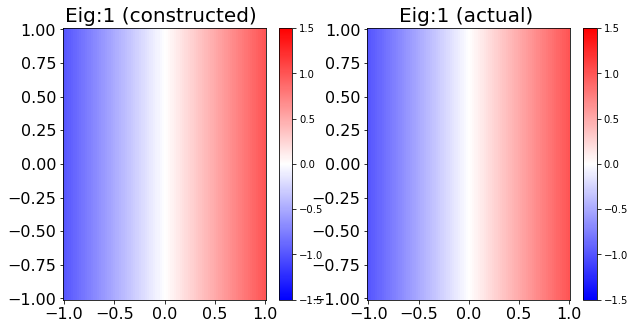

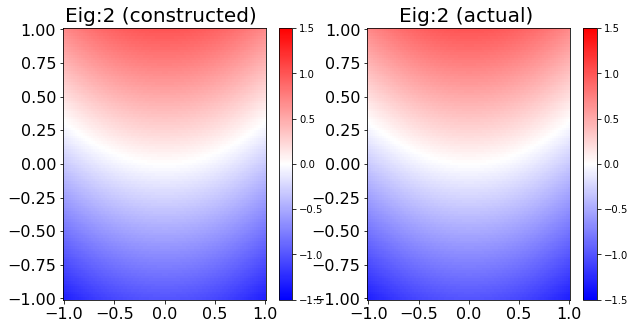

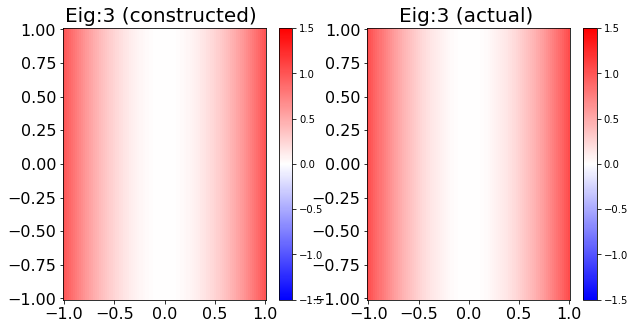

In [28]:
psi_val_plot=find_eigenfunctions1(x_plot, deg_l=degreelist, coef0=coef0)
# psi_val_plot=pvp
x_lifted = lambda x:np.array([x[:,0], x[:,1], x[:,0]**2]).T
z = x_lifted(x_plot)
psi_original = z@w_K

for l in range(psi_val_plot.shape[1]):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    phi_pred = np.reshape(psi_val_plot[:,l],(N1,N2))
    plt.pcolormesh(x1g,x2g,np.real(phi_pred), cmap='bwr', vmin=-1.5, vmax=1.5, shading='auto')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Eig:'+str(l+1)+' (constructed) ',fontsize=20)
    plt.colorbar()
    
    plt.subplot(1,2,2)
    phi_orig = np.reshape(psi_original[:,l],(N1,N2))
    plt.pcolormesh(x1g,x2g,np.real(phi_orig), cmap='bwr', vmin=-1.5, vmax=1.5, shading='auto')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Eig:'+str(l+1)+' (actual) ',fontsize=20)
    plt.colorbar()
    
    plt.show()

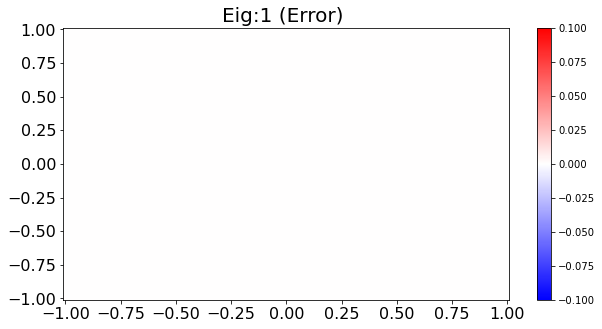

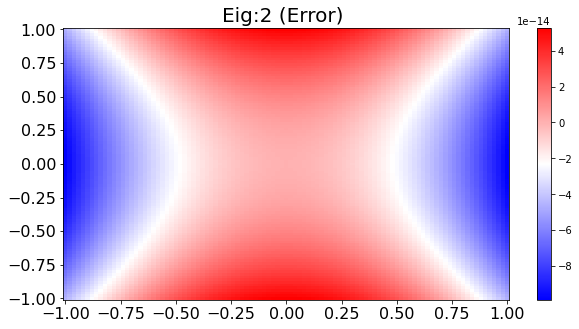

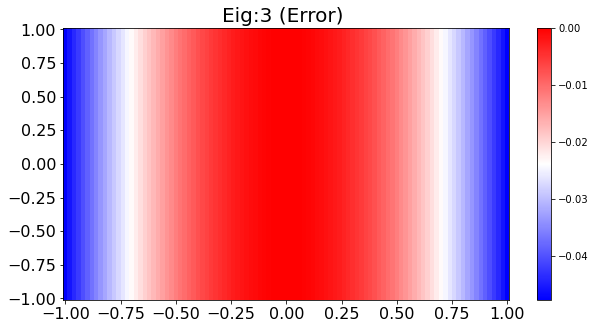

In [29]:
for l in range(psi_val_plot.shape[1]):
    plt.figure(figsize=(10,5))
    phi_pred = np.reshape(psi_val_plot[:,l],(N1,N2))
    phi_orig = np.reshape(psi_original[:,l],(N1,N2))
    plt.pcolormesh(x1g,x2g,np.real(phi_pred)-np.real(phi_orig), cmap='bwr', shading='auto')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Eig:'+str(l+1)+' (Error) ',fontsize=20)
    plt.colorbar()
    
    plt.show()
    


In [30]:
err_mat = np.real(psi_val_plot)-np.real(psi_original)
err_mat.shape

(10201, 3)

In [31]:
# 1st eigenfunction 
print('first eigenfunction errors:')
#mean absolute error
err_mean_abs_e1 = np.abs(err_mat[:,0]).mean()
print('mean absolute error:',err_mean_abs_e1)

#max absolute error
err_max_abs_e1 = np.abs(err_mat[:,0]).max()
print('max absolute error :',err_max_abs_e1)

#mean squared error
err_mean_sqrd_e1 = (err_mat[:,0]**2).mean()
print('mean squared error :',err_mean_sqrd_e1)

#error 2-norm
err_2_norm_e1 = np.linalg.norm(err_mat[:,0],2)
print('error 2-norm       :',err_2_norm_e1)
print()

# 2nd eigenfunction 
print('second eigenfunction errors:')
#mean absolute error
err_mean_abs_e2 = np.abs(err_mat[:,1]).mean()
print('mean absolute error:',err_mean_abs_e2)

#max absolute error
err_max_abs_e2 = np.abs(err_mat[:,1]).max()
print('max absolute error :',err_max_abs_e2)

#mean squared error
err_mean_sqrd_e2 = (err_mat[:,1]**2).mean()
print('mean squared error :',err_mean_sqrd_e2)

#error 2-norm
err_2_norm_e2 = np.linalg.norm(err_mat[:,1],2)
print('error 2-norm       :',err_2_norm_e2)

first eigenfunction errors:
mean absolute error: 0.0
max absolute error : 0.0
mean squared error : 0.0
error 2-norm       : 0.0

first eigenfunction errors:
mean absolute error: 2.874222184146673e-14
max absolute error : 9.875433804040767e-14
mean squared error : 1.4033307458251929e-27
error 2-norm       : 3.783566695350142e-12


In [32]:
C_1=C_opt[1]
X_1=x_ins_comb[:,0]
X_2=x_ins_comb[:,1]

In [33]:
x1_sqr_coef = (C_1*(X_1**2)).sum()
x2_sqr_coef = (C_1*(X_2**2)).sum()
x1_x2_coef = (2*C_1*X_1*X_2).sum()

print('X_1^2 coefficient is   : ', x1_sqr_coef)
print('X_2^2 coefficient is   : ', x2_sqr_coef)
print('X_1 X_2 coefficient is : ', x1_x2_coef)

X_1^2 coefficient is   :  -0.3123837857940742
X_2^2 coefficient is   :  5.2621101920280466e-14
X_1 X_2 coefficient is :  2.7755575615628914e-17


In [34]:
x1_sqr_coef=x1_sqr_coef.round(4)
x2_sqr_coef=x2_sqr_coef.round(4)
x1_x2_coef=x1_x2_coef.round(4)
print(x1_sqr_coef,x2_sqr_coef,x1_x2_coef)

-0.3124 0.0 0.0


In [35]:
beta=-(lam_x2/(lam_x2-mu**2))

In [36]:
eig_2_data = x_plot[:,1] + (beta*(x_plot[:,0]**2) \
            + x1_x2_coef*((x_plot[:,0]**2)*(x_plot[:,1]**2)) \
            + x2_sqr_coef*(x_plot[:,1]**2))

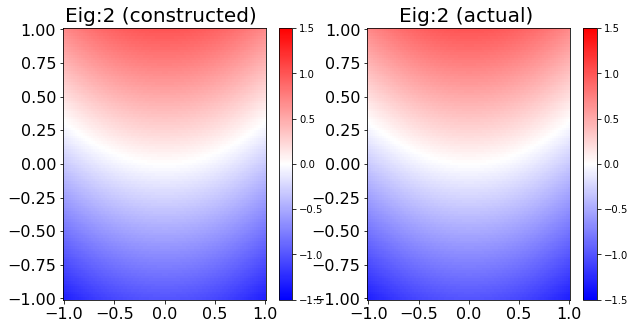

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
eig2_pred = np.reshape(eig_2_data,(N1,N2))
plt.pcolormesh(x1g,x2g,np.real(eig2_pred), cmap='bwr', vmin=-1.5, vmax=1.5, shading='auto')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Eig:'+str(2)+' (constructed) ',fontsize=20)
plt.colorbar()

plt.subplot(1,2,2)
phi_orig = np.reshape(psi_original[:,1],(N1,N2))
plt.pcolormesh(x1g,x2g,np.real(phi_orig), cmap='bwr', vmin=-1.5, vmax=1.5, shading='auto')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Eig:'+str(2)+' (actual) ',fontsize=20)
plt.colorbar()

plt.show()

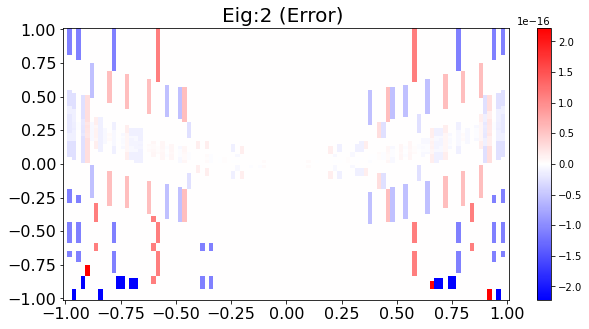

In [38]:
plt.figure(figsize=(10,5))
eig2_pred = np.reshape(eig_2_data,(N1,N2))
eig2_orig = np.reshape(psi_original[:,1],(N1,N2))
plt.pcolormesh(x1g,x2g,np.real(eig2_pred)-np.real(eig2_orig), cmap='bwr', shading='auto')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Eig:'+str(2)+' (Error) ',fontsize=20)
plt.colorbar()

plt.show()

In [39]:
print(beta.round(4))
print(x1_sqr_coef, x2_sqr_coef, x1_x2_coef)

-0.3124
-0.3124 0.0 0.0
